In [548]:
import numpy as np
import math
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [549]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [550]:
f(3.0)

20.0

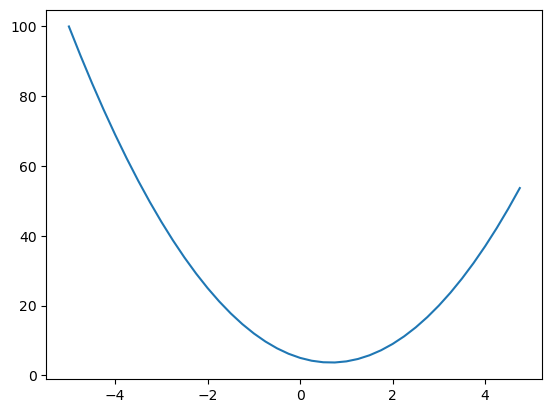

In [551]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

This is the definition of a derivative: 

$$
\lim_{h \to 0} \frac{f(a + h) - f(a)}{h}
$$

As $h \longrightarrow 0$, then we can iteratively see how the function begins to respond--the sensitivity of the function--based on some value $a$. All this is is the slope!

In [552]:
h = 0.00001
x = -3.0
((f(x + h) - f(x))) / h

-21.999970000052823

A slightly more complex case:

In [553]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


Idea of partial derivatives: how do incremental changes in each individual input affect the overall output? If we increase $a$ by a small amount then we can see the rate of change of $d$ with respect to $a$.

In [554]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
a += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


# Value Class 1

We can implement a new `Value` class that implements `__add__` and `__mul__` to represent basic mathematical operations. `Value` will allow us to represent basic "nodes" on a graph that represent some input to or output of a mathematical operation.

In [555]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
print(a + b, a * b)

Value(data=-1.0) Value(data=-6.0)


# Value Class 2

We want to use these `Value` objects as components of an expression graph. To do this, each node should record what children they have. For the graph, we'll also want to keep the operation that was used to produce the values.

In [556]:
class Value:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.name = name

    def __repr__(self):
        return f"Value(data={self.data}, label={self.name if self.name else None})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, name='a')
b = Value(-3.0, name='b')
c = Value(10.0, name='c')
e = a * b
e.name = 'e'
d = e + c
d.name = 'd'
f = Value(-2.0, name='f')
L = d * f
L.name = 'L'
d._prev, d._op

({Value(data=-6.0, label=e), Value(data=10.0, label=c)}, '+')

$d$ was produced as an **addition** of these two children values.

In [557]:
from graphviz import Digraph

# Recursively builds out a directed graph of previous nodes to their output node
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Given the nodes and edges from the graph, draw out a visualization of the operations
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | data %.4f }" % (n.name, n.data), shape='record')
        if n._op:
            # If this value has an operation, create a node representing the operation
            dot.node(name = uid + n._op, label = n._op)
            # Connect the nodes together
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # Connect the children node to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

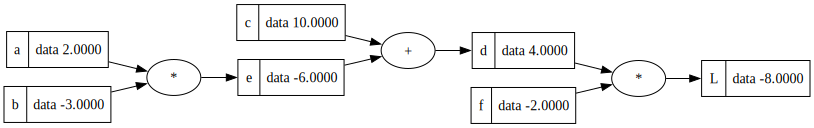

In [558]:
draw_dot(L)

Think of this graph as a visualization of a "forward pass" operation where $L$ is the calculation of some loss criterion. 

$a, b, c, f$ are inputs going into some mathematical operation that produces $L$. What we would like to do next is to run **backpropagation**.

In backpropagation, we start at the last node and reverse the process, calculating the gradient for each intermediate value. For each value, we are computing the derivative of that node with respect to $L$. In a neural network setting, we are interested in the derivative of $L$ with respect to the "weights" of the neural network. We are primarily interested in the derivative of the output with respect to some of the leaf nodes.

# Value Class 3

We will now maintain the gradient of the node. A gradient of 0 means that there is no effect.

In [559]:
class Value:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        # By default, we assume the gradient is 0
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.name = name
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.name if self.name else None})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [560]:
a = Value(2.0, name='a')
b = Value(-3.0, name='b')
c = Value(10.0, name='c')
e = a * b
e.name = 'e'
d = e + c
d.name = 'd'
f = Value(-2.0, name='f')
L = d * f
L.name = 'L'

In [561]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Given the nodes and edges from the graph, draw out a visualization of the operations
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.name, n.data, n.grad), shape='record')
        if n._op:
            # If this value has an operation, create a node representing the operation
            dot.node(name = uid + n._op, label = n._op)
            # Connect the nodes together
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # Connect the children node to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

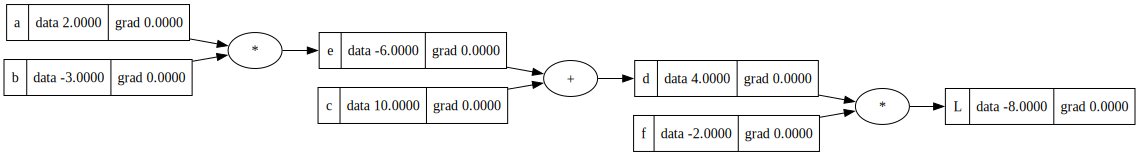

In [562]:
draw_dot(L)

# Backpropagation (Manual): Simple Example

Let's represent $L$ as the operation between $d$ and $f$:

$$
L = d \cdot f
$$

What is the derivative of $L$ with respect to $d$? From calculus we calculate it as $f$! Why?

Recall the derivative definition:

$$
\lim_{h \to 0} \frac{f(a + h) - f(a)}{h}
$$

If we substitute in our operation (keeping in mind we are with respect to $d$) then we get the following:

$$
\lim_{h \to 0} \frac{(d + h) \cdot f - d \cdot f}{h}
$$

This simplifies down to $\lim_{h \to 0} f \longrightarrow f$

In [563]:
def lol():
    h = 0.001

    a = Value(2.0, name='a')
    b = Value(-3.0, name='b')
    c = Value(10.0, name='c')
    e = a * b
    e.name = 'e'
    d = e + c
    d.name = 'd'
    f = Value(-2.0, name='f')
    L = d * f
    L.name = 'L'
    L1 = L.data

    a = Value(2.0, name='a')
    # a.data += h
    b = Value(-3.0, name='b')
    # b.data += h
    c = Value(10.0, name='c')
    e = a * b
    e.name = 'e'
    # e.data += h
    d = e + c
    # d.data += h
    d.name = 'd'
    f = Value(-2.0, name='f')
    f.data += h
    L = d * f
    L.name = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

3.9999999999995595


We can see that the derivative of $L$ with respect to $L$ is 1.0. We will manually set the gradients of $L, f, d$ based on either the formula or manually checking using the `lol` function by adding some small $h$ to the weight we are interested in:

-   $\delta L / \delta f$ = $d$
-   $\delta L / \delta d$ = $f$

In [564]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

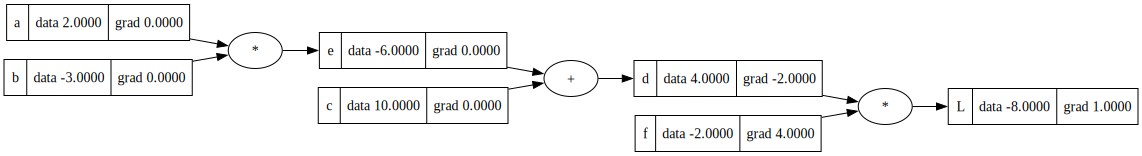

In [565]:
draw_dot(L)

For our next backpropagation step, we need to derive $\frac{\partial L}{\partial c}$ and also $\frac{\partial L}{\partial e}$.

We already calculated $\frac{\partial L}{\partial d}$ so we know how $L$ is "sensitive" to $d$. How is $L$ "sensitive" to $c$? Since $c$ is impacting $d$ and $d$ is impacting $L$, then we should be able to put these pieces together to get the impact of $c$ on $L$.

Mathematically, we can derive the impact of $c$ on $d$ through the derivative of $d$ with respect to $c$. Since $d = c + e$ the derivative will be 1.0. The same applies with respect to $e$. These are the **local** derivatives, but we want the derivative of $L$ with respect to these nodes. 

The answer to this is the **chain rule** in calculus! The chain rule can be expressed as:

$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

We multiply these intermediate derivatives to get the derivative we want!

A story example: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 times 4 equals 8 times as fast as the man."

Gradient refers to overall derivative of $L$ with respect to the node. You can imagine that the derivative is flowing backwards throughout the graph. For the gradients at $c$ and $e$ these are just 1 times the gradient of $L$ with respect to $d$.

In [566]:
c.grad = -2.0
e.grad = -2.0

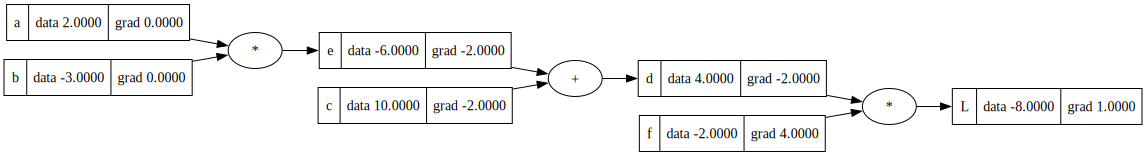

In [567]:
draw_dot(L)

Finally, let's do the same for $a$ and $b$.

$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial a} = 6.0
$$
$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial b} = -4.0
$$

In [568]:
a.grad = 6.0
b.grad = -4.0

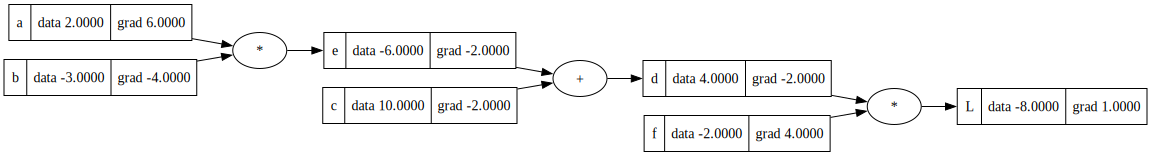

In [569]:
draw_dot(L)

To summarize, we iterated through all the nodes and locally applied the chain rule. Each node has some operation that we can calculate the local derivative on. Starting from the $L$ node, we calculated the derivative of $L$ with respect to the direct children and recursively multiplied the local derivatives backwards throughout the graph to get all the gradients.

In a neural network, we can use these gradients to update our weights using small "step sizes". We'll run one step of an optimization step here.

In [570]:
lr = 0.01
a.data += lr * a.grad
b.data += lr * b.grad
c.data += lr * c.grad
f.data += lr * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


# Backpropagation (Manual): Neuron

In a neuron, we have some input $x$ and then "synapses" with weights. Synapses interact with the input to the neuron multiplicatively: $w_0x_0$ for example. We then sum over all these interactions with some bias, $b$, added.

$$
\sum_i w_ix_i + b
$$

After we sum our weights together with the bias, we feed the output to an **activation function**. According to Andrej, this is typically some sort of "squashing" function like tanh or sigmoid.

In this case, we will use the tanh activation function.

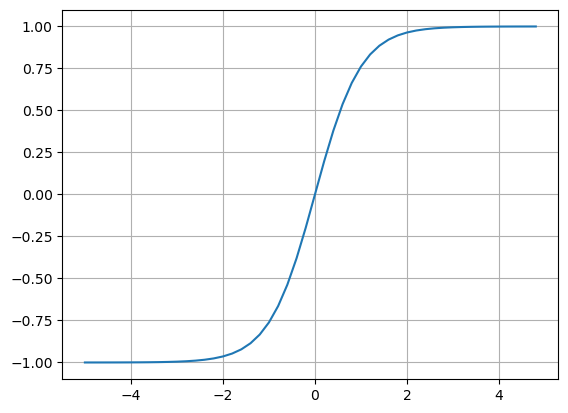

In [571]:
x = np.arange(-5, 5, 0.2)
plt.plot(x, np.tanh(x))
plt.grid()

## Implementing tanh

In order to use our `Value` class we will have to implement some method to calculate tanh.

In [572]:
def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

Value.tanh = tanh

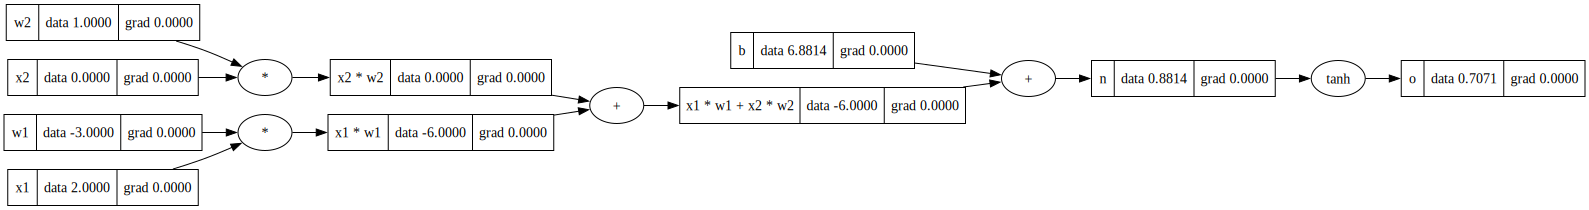

In [573]:
# inputs x1, x2
x1 = Value(2.0, name='x1')
x2 = Value(0.0, name='x2')

# weights w1, w2
w1 = Value(-3.0, name='w1')
w2 = Value(1.0, name='w2')

# Bias of the neuron
b = Value(6.8813735870195432, name='b')

x1w1 = x1 * w1; x1w1.name = 'x1 * w1'
x2w2 = x2 * w2; x2w2.name = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.name = 'n'
o = n.tanh()
o.name = 'o'
draw_dot(o)

As long as we know the derivative of the activation function, we can use the chain rule to calculate the derivative of the output with respect to the input.

In [574]:
o.grad = 1.0

# Derivative of tanh is 1 - tanh^2
n.grad = round(1 - o.data ** 2, 1)

x1w1x2w2.grad = 1 * 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

# Using chain rule to calculate gradients for the input weights
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad

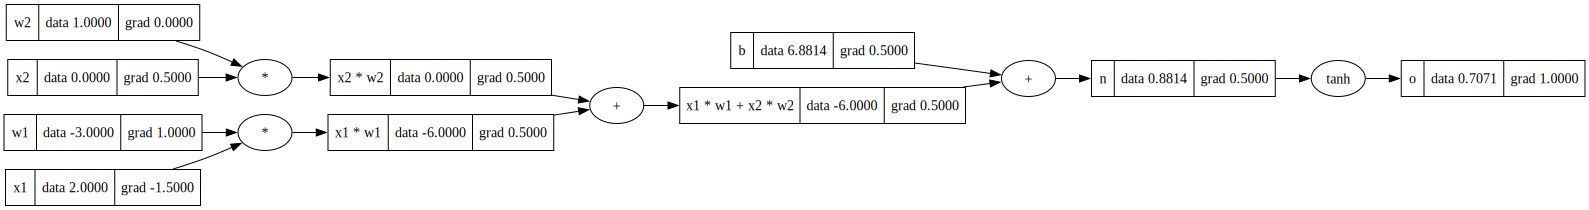

In [575]:
draw_dot(o)

There seems to be pattern with the chain rule operations we are doing for each node. We can now implement this into the `Value` class.

# Value Class 4

We will store a function which is doing the local piece of chain rule at each node. We are storing how we are going to chain the output gradient to the input gradient.

In [576]:
class Value:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        # By default, we assume the gradient is 0
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.name = name
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.name if self.name else None})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # For addition, we want to take "out" grad and propagate it into self grad and other grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # In the multiplication case, the derivative with respect to an input is the other output.
            # We use chain rule to multiply the local derivative and output derivative to get the gradients for the previous node
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # Use the local derivative of tanh to calculate the gradient for the previous node
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

We'll redefine our forward pass again, but now we don't have to calculate derivatives manually. We can call 

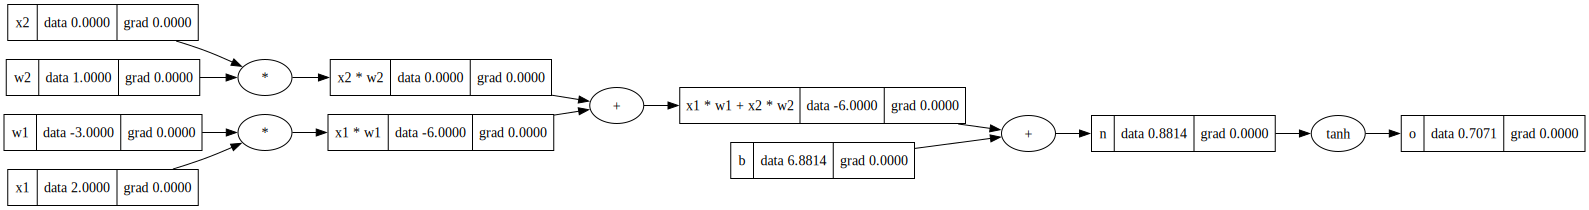

In [577]:
# inputs x1, x2
x1 = Value(2.0, name='x1')
x2 = Value(0.0, name='x2')

# weights w1, w2
w1 = Value(-3.0, name='w1')
w2 = Value(1.0, name='w2')

# Bias of the neuron
b = Value(6.8813735870195432, name='b')

x1w1 = x1 * w1; x1w1.name = 'x1 * w1'
x2w2 = x2 * w2; x2w2.name = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.name = 'n'
o = n.tanh()
o.name = 'o'
draw_dot(o)

In [578]:
# Base case is 1 since derivative of output with respect to itself is 1 and we don't want to multiply by the initial 0 gradient
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

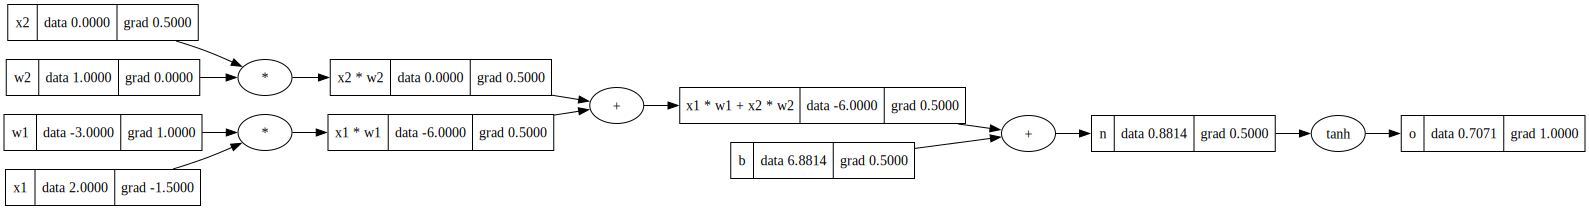

In [579]:
draw_dot(o)

Going backwards through the graph / expression, we never want to call `_backward` before we've done all the operations coming after it. The ordering of graphs can be achieved using topological sort.

In [580]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        # Add the children to the list before the parents
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543, label=b),
 Value(data=0.0, label=x2),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2 * w2),
 Value(data=2.0, label=x1),
 Value(data=-3.0, label=w1),
 Value(data=-6.0, label=x1 * w1),
 Value(data=-6.0, label=x1 * w1 + x2 * w2),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=o)]

# Value Class 5

We can automate the backwards process while maintaining the correct order of the graph by adding a new `backward` method to the `Value` class.

In [581]:
class Value:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        # By default, we assume the gradient is 0
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.name = name
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.name if self.name else None})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # For addition, we want to take "out" grad and propagate it into self grad and other grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        # Whenever we apply the addition operation, assign the differentiation method for addition to the output Value to be used during backprop
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # In the multiplication case, the derivative with respect to an input is the other output.
            # We use chain rule to multiply the local derivative and output derivative to get the gradients for the previous node
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        # Whenever we apply the multiply operation, assign the differentiation method for multiplication to the output Value to be used during backprop
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                # Add the children to the list before the parents
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # Use the local derivative of tanh to calculate the gradient for the previous node
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

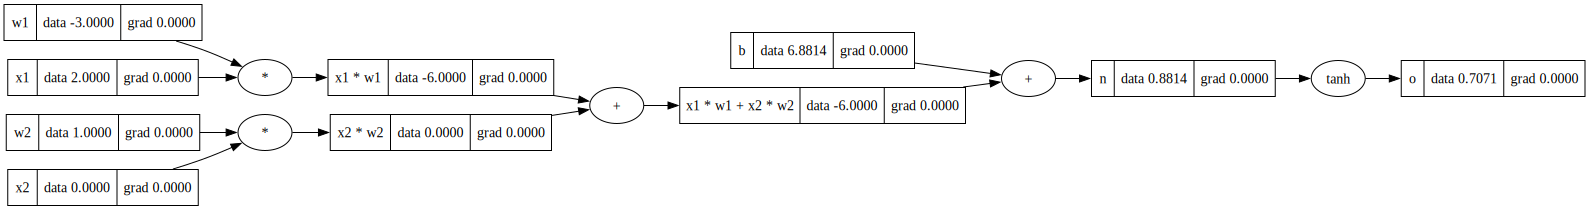

In [582]:
# inputs x1, x2
x1 = Value(2.0, name='x1')
x2 = Value(0.0, name='x2')

# weights w1, w2
w1 = Value(-3.0, name='w1')
w2 = Value(1.0, name='w2')

# Bias of the neuron
b = Value(6.8813735870195432, name='b')

x1w1 = x1 * w1; x1w1.name = 'x1 * w1'
x2w2 = x2 * w2; x2w2.name = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.name = 'n'
o = n.tanh()
o.name = 'o'
draw_dot(o)

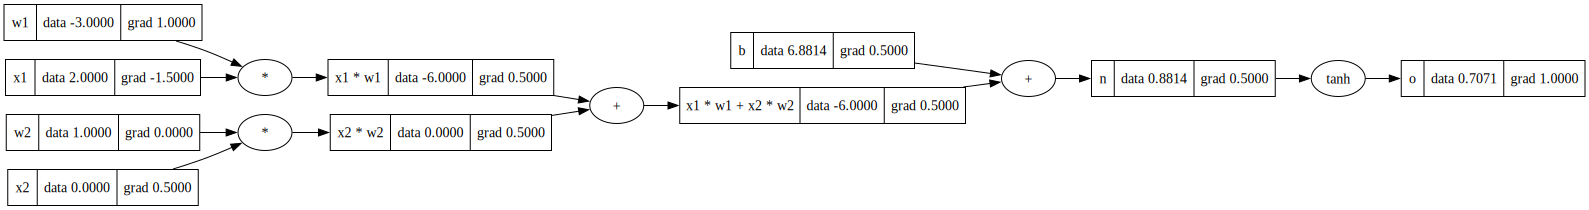

In [583]:
o.backward()
draw_dot(o)

However, there is a major issue with this implementation. If nodes are used more than once in operations then the gradients will overwrite themselves. The solution is to accumulate the gradients from the multivariate case. Any contribution that flows backwards through a node should be added to the gradient.

# Value Class 6

In [584]:
class Value:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        # By default, we assume the gradient is 0
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.name = name
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.name if self.name else None})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # For addition, we want to take "out" grad and propagate it into self grad and other grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # Whenever we apply the addition operation, assign the differentiation method for addition to the output Value to be used during backprop
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # In the multiplication case, the derivative with respect to an input is the other output.
            # We use chain rule to multiply the local derivative and output derivative to get the gradients for the previous node
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # Whenever we apply the multiply operation, assign the differentiation method for multiply to the output Value to be used during backprop
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                # Add the children to the list before the parents
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # Use the local derivative of tanh to calculate the gradient for the previous node
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

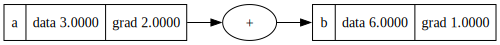

In [585]:
a = Value(3.0, name='a')
b = a + a; b.name = 'b'
b.backward()
draw_dot(b)

# Value Class 7

In [586]:
class Value:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        # By default, we assume the gradient is 0
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.name = name
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.name if self.name else None})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # For addition, we want to take "out" grad and propagate it into self grad and other grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # Whenever we apply the addition operation, assign the differentiation method for addition to the output Value to be used during backprop
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (-other) 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # In the multiplication case, the derivative with respect to an input is the other output.
            # We use chain rule to multiply the local derivative and output derivative to get the gradients for the previous node
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # Whenever we apply the multiply operation, assign the differentiation method for multiply to the output Value to be used during backprop
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
        
    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other ** -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int and float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                # Add the children to the list before the parents
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # Use the local derivative of tanh to calculate the gradient for the previous node
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

In [587]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5, label=None)

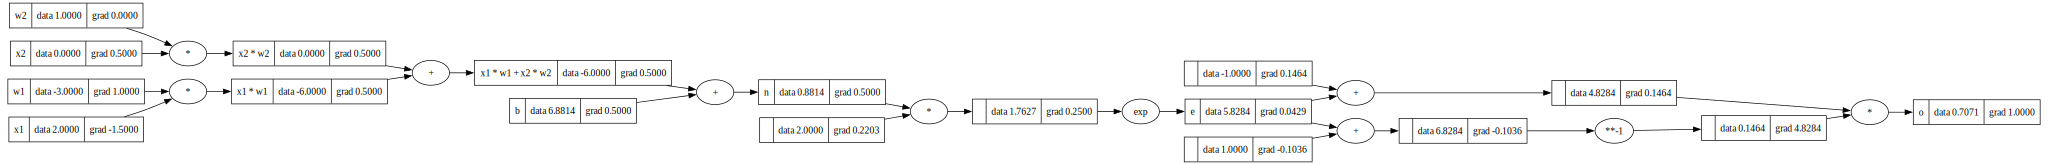

In [588]:
# inputs x1, x2
x1 = Value(2.0, name='x1')
x2 = Value(0.0, name='x2')

# weights w1, w2
w1 = Value(-3.0, name='w1')
w2 = Value(1.0, name='w2')

# Bias of the neuron
b = Value(6.8813735870195432, name='b')

x1w1 = x1 * w1; x1w1.name = 'x1 * w1'
x2w2 = x2 * w2; x2w2.name = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.name = 'n'
# ----
e = (2 * n).exp(); e.name = 'e'
o = (e - 1) / (e + 1)
o.name = 'o'
o.backward()
draw_dot(o)

Summary:

-   You can decide what level you want to implement your operations at. You can implement backward passes for tiny operations like addition and subtraction or for composite operations like tanh.
-   All that matters is we have some inputs and some output. This output is some function of the inputs in some way. As long as you can do the forward and backward pass of the operation it doesn't matter what that operation is. With local gradients, we can chain together the gradients to get the overall gradient. The design of the function is completely up to you.

# Using PyTorch

If we were to do the same thing in PyTorch, we can create single element tensors which represent our previous weights and inputs. In PyTorch, you have to explicitly state which tensors should have their gradients calculated.

In [589]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad_()
x2 = torch.Tensor([0.0]).double(); x2.requires_grad_()
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad_()
w2 = torch.Tensor([1.0]).double(); w2.requires_grad_()

b = torch.Tensor([6.8813735870195432]).double()

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
o.backward()

print(o.item())
print("------")
print("x1", x1.grad.item())
print("x2",x2.grad.item())
print("w1",w1.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
------
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


# Neural Net from Scratch

In [590]:
class Neuron:
    def __init__(self, n_in):
        # Randomly initialize weights and biases
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # Create the forward pass expression
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.6454599297508109, label=None)

In [591]:
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.49841600520319357, label=None),
 Value(data=-0.9436429988771529, label=None),
 Value(data=0.9999041818319558, label=None)]

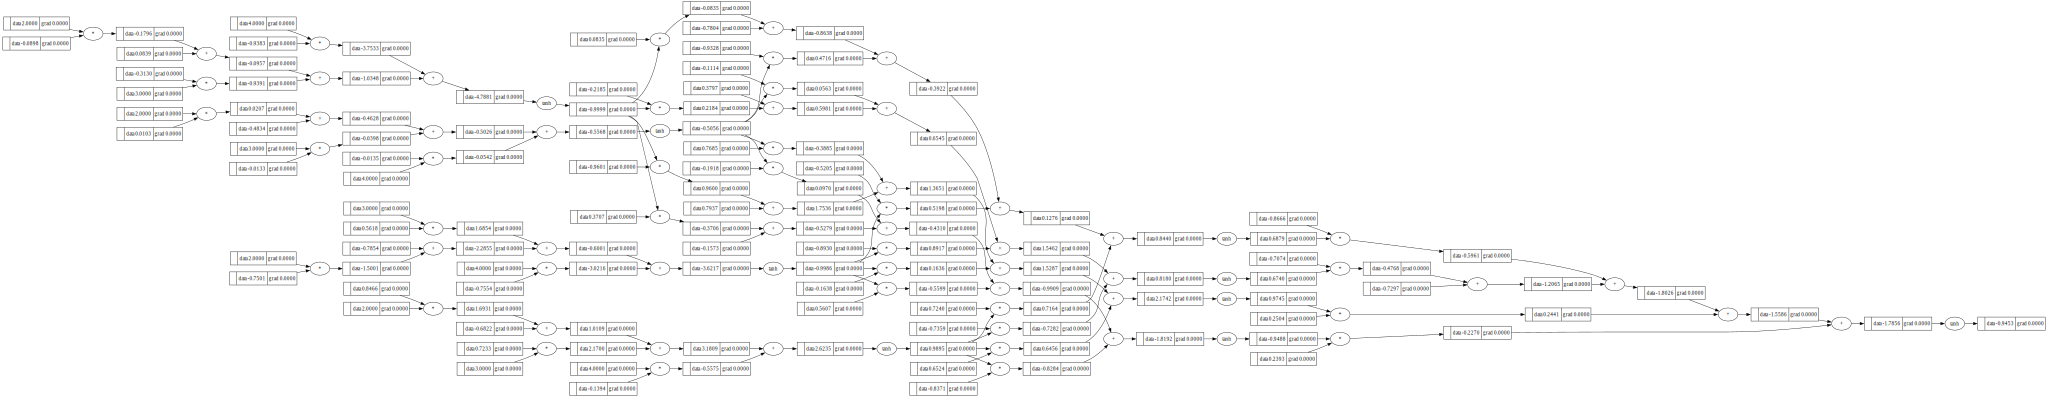

In [592]:
class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(n_outs))]

    def __call__(self, x):
        # Forward pass through each layer we created in our neural net
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
draw_dot(n(x))

In [593]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5665565607513282, label=None),
 Value(data=-0.9354219259522293, label=None),
 Value(data=-0.9054802378842677, label=None),
 Value(data=-0.760269826993214, label=None)]

In [594]:
def binary_cross_entropy(pred, ys):
    scaled_ys = [(y + 1) / 2 for y in ys]
    scaled_pred = [(p + 1) / 2 for p in pred]
    n = len(pred)
    logits = [-(yi * math.log(pi.data) + (1 - yi) * math.log(1 - pi.data)) for yi, pi in zip(scaled_ys, scaled_pred)]
    return 1 / n * sum(logits)

binary_cross_entropy(ypred, ys)

0.9329411332275923

In [595]:
def mse_loss(pred, ys):
    loss = sum((yi - yt) ** 2 for yi, yt in zip(pred, ys))
    return loss

loss = mse_loss(ypred, ys)

In [596]:
loss.backward()

In [597]:
n.layers[0].neurons[0].w[0].grad

-0.08470859467429787

In [598]:
n.layers[0].neurons[0].w[0]

Value(data=-0.08982337478079083, label=None)

In [599]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [600]:
ypred = [n(x) for x in xs]
loss = mse_loss(ypred, ys)
loss.backward()
ypred

[Value(data=0.0770582817840508, label=None),
 Value(data=-0.9111037078895028, label=None),
 Value(data=-0.8684908791912934, label=None),
 Value(data=-0.47108919501783464, label=None)]

In [607]:
n = MLP(3, [4, 4, 1])
training_loss = []
epoch = []
for i in range(20):
    ypred = [n(x) for x in xs]
    loss = mse_loss(ypred, ys)
    print(f'Loss at epoch {i}: {loss.data:0.8f}')
    epoch.append(i) 
    training_loss.append(loss.data)
    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad

print(ypred)

Loss at epoch 0: 4.61333961
Loss at epoch 1: 3.71315592
Loss at epoch 2: 2.38008684
Loss at epoch 3: 1.38836248
Loss at epoch 4: 0.74965027
Loss at epoch 5: 0.31920242
Loss at epoch 6: 0.11065877
Loss at epoch 7: 0.03306334
Loss at epoch 8: 0.00892086
Loss at epoch 9: 0.00234749
Loss at epoch 10: 0.00064896
Loss at epoch 11: 0.00019813
Loss at epoch 12: 0.00006888
Loss at epoch 13: 0.00002798
Loss at epoch 14: 0.00001371
Loss at epoch 15: 0.00000848
Loss at epoch 16: 0.00000708
Loss at epoch 17: 0.00000891
Loss at epoch 18: 0.00002117
Loss at epoch 19: 0.00013722
[Value(data=0.9893502126561426, label=None), Value(data=-0.9999477081377143, label=None), Value(data=-0.999942113560697, label=None), Value(data=0.9951219869246463, label=None)]


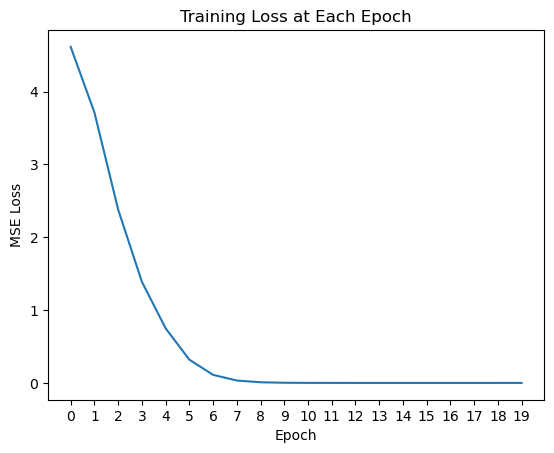

In [608]:
plt.plot(epoch, training_loss)
plt.title("Training Loss at Each Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.xticks(epoch)
plt.show()